## Import data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%cd ..

/mnt/d/anomaly-detection


In [5]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [6]:
window_length = 64
stride = 0

X = np.array([
    data.iloc[i - window_length:i].to_numpy().flatten()
    for i in range(window_length, data.shape[0] - window_length - stride)
]).reshape(-1, window_length, data.shape[1])

## Train model

In [10]:
def split_by_3rd_dim(X):
    squeeze = lambda els: list(map(lambda el: el.squeeze(), els))
    return squeeze(np.dsplit(X, X.shape[2]))

In [11]:
from src.models.autoencoder import build_matrix_autoencoder
import keras

create_params = dict(
    input_shape=window_length,
    hidden_layers_size=[32],
    reg_strength=0.01,
    input_dropout=0.1,
)

compile_params = dict(
    optimizer=keras.optimizers.Adam(lr=0.1),
)

fit_params = dict(
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.2, verbose=1),
               keras.callbacks.EarlyStopping(min_delta=0.01, patience=20)]
)


model_fn = lambda: build_matrix_autoencoder(X.shape[2], create_params, compile_params)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tssplit = TimeSeriesSplit(n_splits=3)
results = []

for i, (train_idx, test_idx) in enumerate(tssplit.split(X, X)):
    print(f'Fold {i}...')
    model = model_fn()
    
    X_tr = split_by_3rd_dim(X[train_idx])
    X_val = split_by_3rd_dim(X[test_idx])
    
    history = model.fit(X_tr,
                        X_tr,
                        validation_data=(X_val, X_val),
                        **fit_params)
    results.append(history.history)

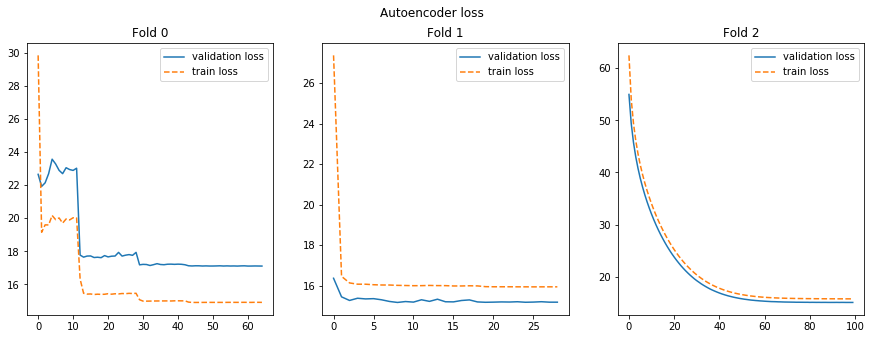

In [7]:
from src.visualization.visualize import visualize_result
visualize_result(results, f'Autoencoder loss')

In [ ]:
squeeze = lambda els: list(map(lambda el: el.squeeze(), els))
X_tr = squeeze(np.dsplit(X, X.shape[2]))

model = model_fn()
model.fit(X_tr, X_tr, **fit_params)
               
model.save('models/matrix_autoencoder.h5')

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_165 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_166 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_167 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_168 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_169 

## Extract first layer that can embedes data

In [1]:
import keras
from keras.layers import Input
from keras.models import Model, load_model

Using TensorFlow backend.


In [7]:
model = load_model('models/matrix_autoencoder.h5')

W0916 15:48:06.877967 139803266910016 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 15:48:06.924201 139803266910016 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 15:48:06.925007 139803266910016 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0916 15:48:06.933735 139803266910016 deprecation.py:506] From /home/elch10/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with k

In [8]:
seq_models = [layer for layer in model.layers if 'sequential' in layer.name]

encoder_layers = [seq_model.layers[1] for seq_model in seq_models]

In [12]:
inputs = [Input(shape=(create_params['input_shape'],)) for i in range(len(encoder_layers))]
encoded = [encoder(input) for input, encoder in zip(inputs, encoder_layers)]

encoder = Model(inputs=inputs, outputs=encoded)

In [13]:
encoded_X = encoder.predict(split_by_3rd_dim(X))
encoded_X = np.array(encoded_X)

First lets transform data

In [14]:
print(encoded_X.shape)

(41, 12673, 32)


In [15]:
encoded_X = np.swapaxes(encoded_X, 0, 1)
encoded_X = np.swapaxes(encoded_X, 1, 2)
print(encoded_X.shape)

(12673, 32, 41)


In [16]:
encoded_X = encoded_X.reshape(-1, encoded_X.shape[1]*encoded_X.shape[2])

## Plotting

In [17]:
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

def plot(embeddings, cluster_predictions):
    vis_x = embeddings[:, 0]
    vis_y = embeddings[:, 1]
    plt.scatter(vis_x, vis_y, c=cluster_predictions, marker='.')
    print(f'Counts of every value: {np.bincount(cluster_predictions)}')

def pca_plot(cluster_predictions):
    if not hasattr(pca_plot, 'X_embedded'):
        pca_plot.pca = PCA(n_components=2)
        pca_plot.X_embedded = pca_plot.pca.fit_transform(encoded_X)
    
    plt.title(f'Explained ration is {sum(pca_plot.pca.explained_variance_ratio_):.2f}')
    plot(pca_plot.X_embedded, cluster_predictions)

def TSNE_plot(cluster_predictions):
    if not hasattr(pca_plot, 'embeddings'):
        TSNE_plot.tsne = TSNE(n_jobs=-1)
        TSNE_plot.embeddings = TSNE_plot.tsne.fit_transform(encoded_X)
        
    plt.title(f'KL divergence {TSNE_plot.tsne.kl_divergence_:.2f}')
    plot(TSNE_plot.embeddings, cluster_predictions)

## Clustering

### KMeans

Lets find optimal value for clusters amount

In [18]:
from sklearn.preprocessing import StandardScaler
encoded_X = StandardScaler().fit_transform(encoded_X)

In [19]:
from sklearn.cluster import KMeans

/home/elch10/miniconda3/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/elch10/miniconda3/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/elch10/miniconda3/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


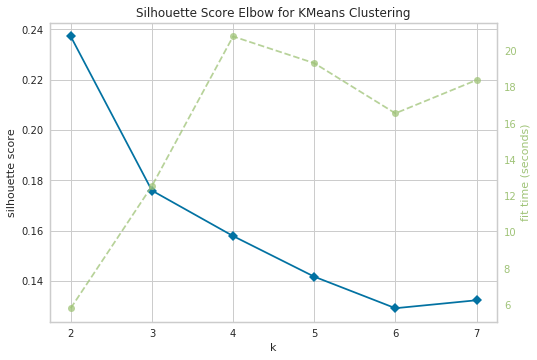

In [83]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette')
visualizer.fit(encoded_X)
visualizer.poof()

W0913 17:05:35.454379 140468095485760 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
W0913 17:05:35.463284 140468095485760 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
W0913 17:05:35.470892 140468095485760 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


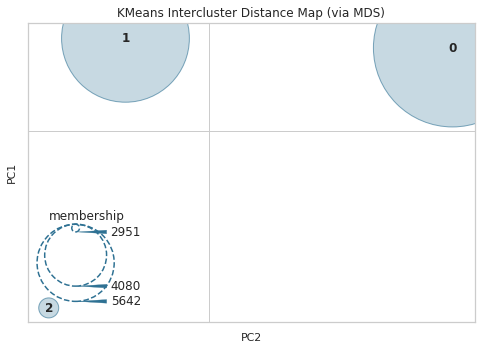

In [18]:
from yellowbrick.cluster import InterclusterDistance

kmeans_3 = KMeans(3)
intra_visualizer = InterclusterDistance(kmeans_3)

intra_visualizer.fit(encoded_X)        # Fit the data to the visualizer
intra_visualizer.poof()        # Draw/show/poof the data

W0916 15:49:30.151972 139803266910016 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
W0916 15:49:30.167185 139803266910016 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
W0916 15:49:30.173820 139803266910016 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


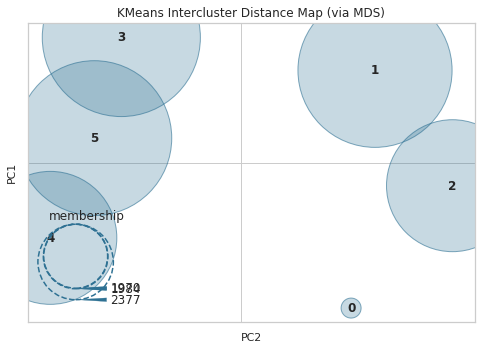

In [20]:
from yellowbrick.cluster import InterclusterDistance

kmeans_6 = KMeans(6)
intra_visualizer = InterclusterDistance(kmeans_6)

intra_visualizer.fit(encoded_X)        # Fit the data to the visualizer
intra_visualizer.poof()        # Draw/show/poof the data

**Можно предположить, что данные из 2 кластера являются аномалиями (KMeans с 3 кластерами)**

In [19]:
pred = kmeans_3.predict(encoded_X)

plt.style.use('default')

Counts of every value: [2951 4087 5635]


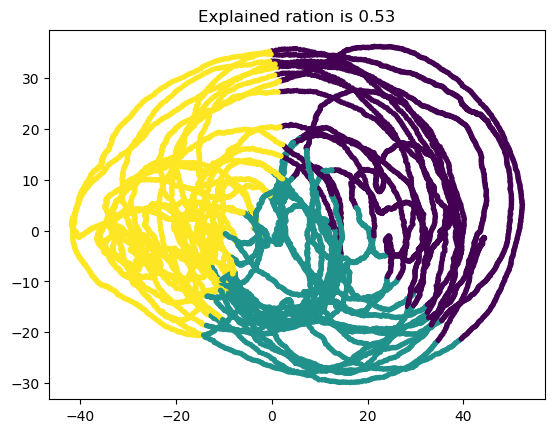

In [102]:
pca_plot(pred)

Counts of every value: [2951 4087 5635]


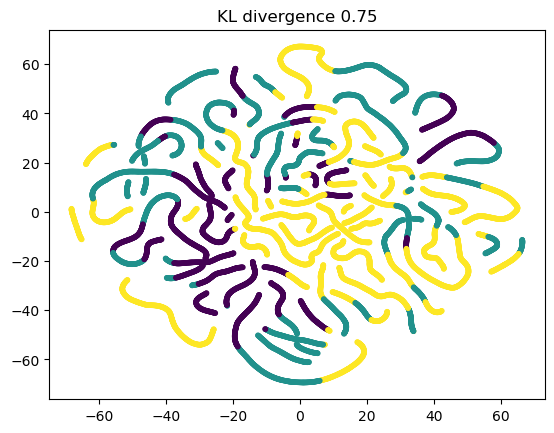

In [103]:
TSNE_plot(pred)

## Check clusterization

In [133]:
# import src.visualization.visualize
# import importlib
# importlib.reload(src.visualization.visualize)

<module 'src.visualization.visualize' from '/mnt/d/anomaly-detection/src/visualization/visualize.py'>

In [20]:
from src.visualization.visualize import plot_random
from src.utils import inverse_ids

In [21]:
anomaly_ids = np.where(pred == 2)[0]
normal_ids = inverse_ids(anomaly_ids, len(encoded_X))

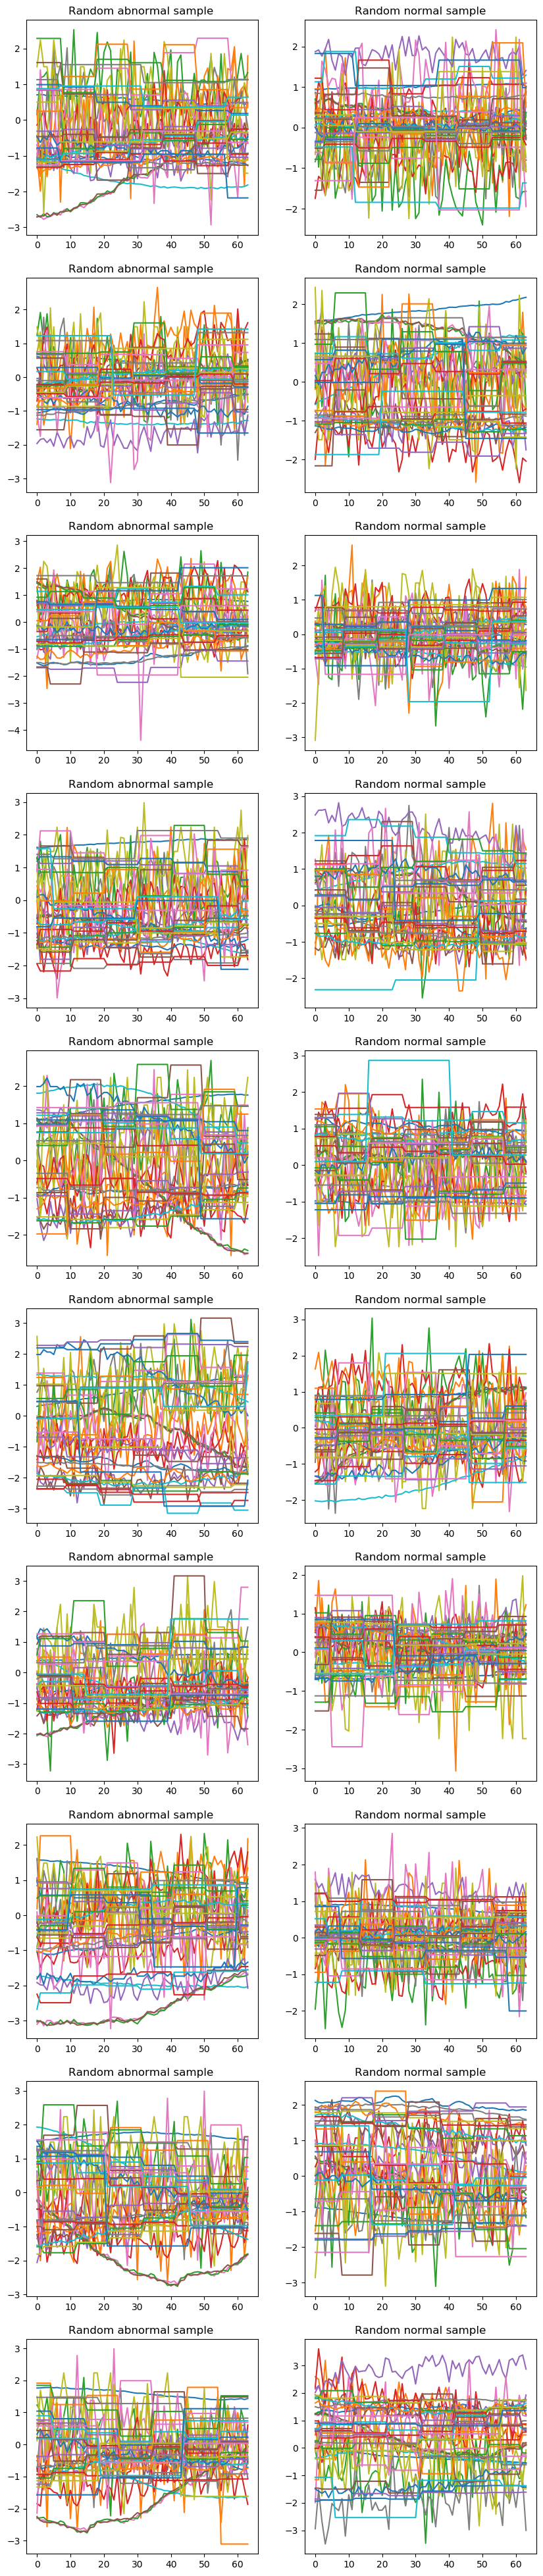

In [22]:
plot_random(X[anomaly_ids], X[normal_ids], 10)